(<Axes: >, <matplotlib.image.AxesImage at 0x7fb74fa97dd0>)

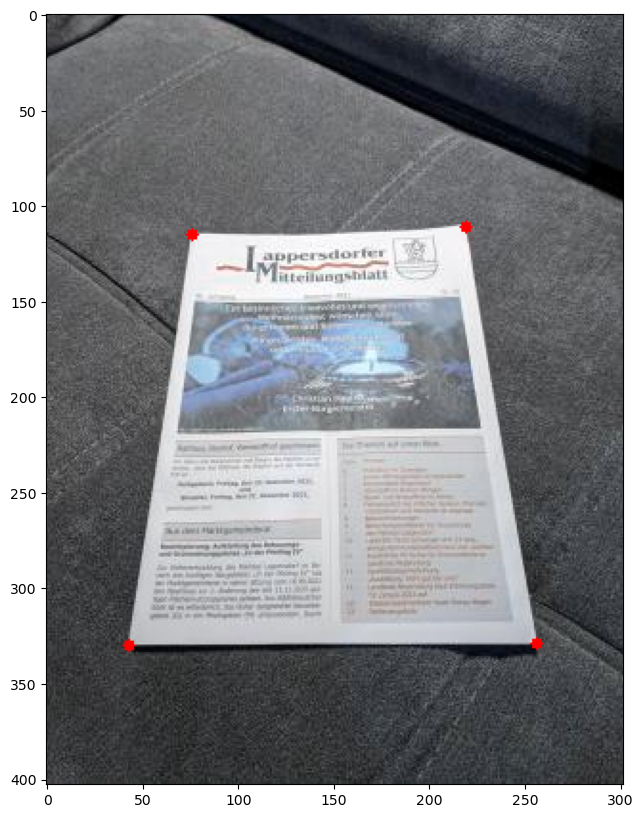

In [22]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

img = cv2.imread('document.jpg')


gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape





cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
plt.imshow(cornerness)

# We are not interested in edges, so put to zero all negative cornerness values
cornerness[cornerness < 0] = 0

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_ritgh = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left     = block[0:quad_size, 0:quad_size]
        quad_top_right    = block[quad_size:, 0:quad_size]
        quad_bottom_left  = block[0:quad_size, quad_size:]
        quad_bottom_right = block[quad_size:, quad_size:]
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)
            
        # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
                   
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)
        # Bottom-left corner
        descriptor = np.mean(quad_top_right) - \
                     np.mean(quad_top_left) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
                   
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)
            
        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
                     np.mean(quad_top_right) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
                   
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

plt.subplot(111), plt.imshow(out)


(<Axes: >, <matplotlib.image.AxesImage at 0x7fb7798ed090>)

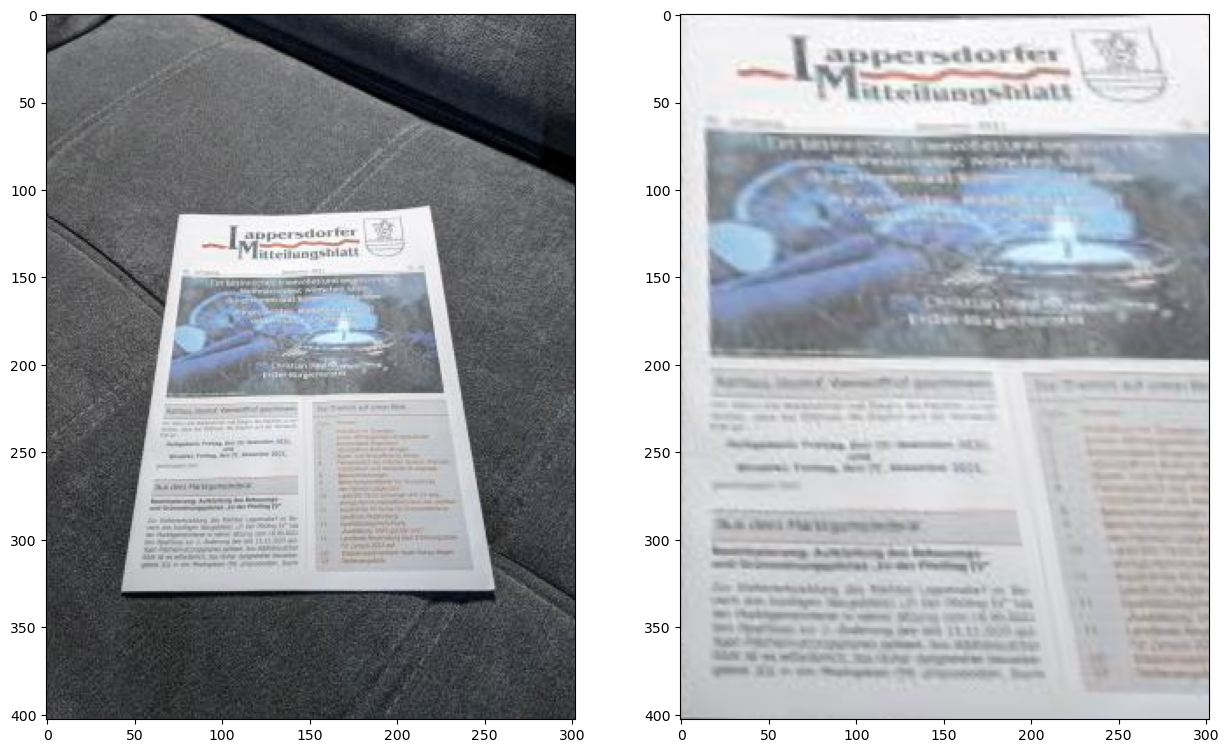

In [2]:
# Define the matrix of source points corresponding to the 4 document corners.
# The matrix shall have shape (4, 2), i.e., 4 corners x 2 coordinates
# Note: You will need to explicitly use float32 data type
src = np.array([top_left, top_right, bottom_left, bottom_right], dtype=np.float32)

# Define the matrix of target (destination) points corresponding to the 4 image corners.
# The matrix shall have shape (4, 2), i.e., 4 corners x 2 coordinates
# Note: You will need to explicitly use float32 data type
# Note2: The order of points in src and dst must be the same
dst = np.array([[0,0], [cols,0], [0, rows], [cols, rows]], dtype=np.float32)

# Compute the affine transform matrix (you'll have to use getAffineTransform function from OpenCV here)
# Use the first 3 points from your src and dst matrix

M = cv2.getAffineTransform(src[:3], dst[:3])

# Build the rectified image using the computed matrix (you'll have to use warpAffine function from OpenCV here)
rectified = cv2.warpAffine(img, M, (cols, rows))

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

(<Axes: >, <matplotlib.image.AxesImage at 0x7fb775a99e90>)

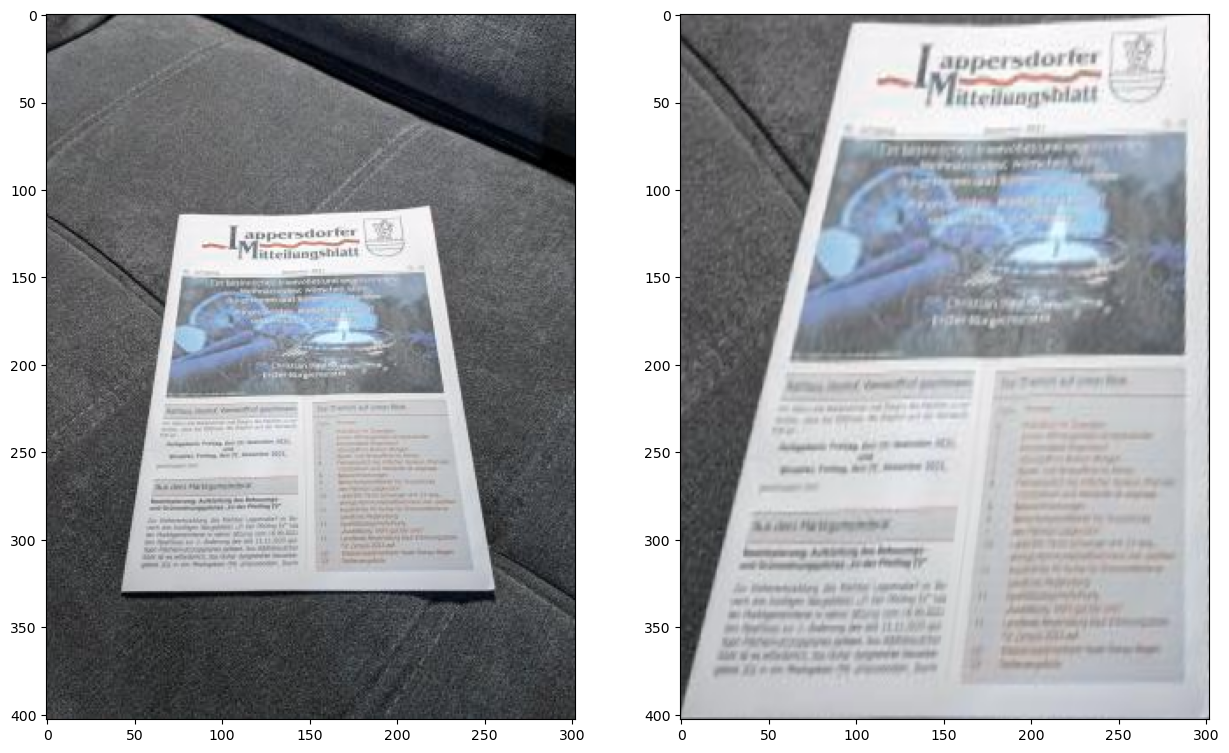

In [3]:
# Compute the affine transform matrix (you'll have to use getAffineTransform function from OpenCV here)
# Use the first 3 points from your src and dst matrix

M = cv2.getAffineTransform(src[1:4], dst[1:4])

# Build the rectified image using the computed matrix (you'll have to use warpAffine function from OpenCV here)
rectified = cv2.warpAffine(img, M, (cols, rows))

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

[[ 2.10190920e+00 -3.56746057e-01 -1.18719303e+02]
 [ 5.14654237e-02  1.83988890e+00 -2.15498595e+02]]


(<Axes: >, <matplotlib.image.AxesImage at 0x7fb770275550>)

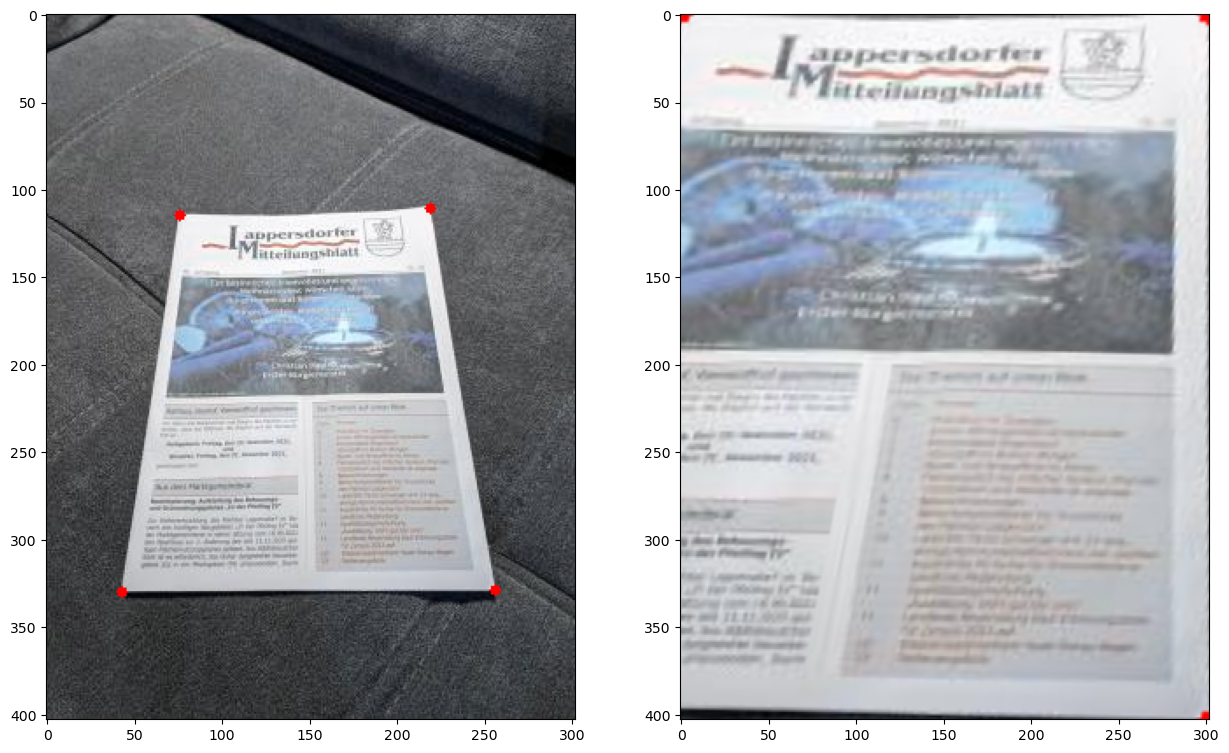

In [25]:
# Estimate the optimal affine transform matrix (you'll have to use estimateAffine2D function from OpenCV here)
# estimateAffine2D it returns the best fitting affine matrix as well as the vector of inliers (1 -> inlier,
# 0 -> outlier).
M, inliers = cv2.estimateAffine2D(src, dst)

# Build the rectified image using the computed matrix (use warpAffine)
rectified = cv2.warpAffine(img, M, (cols, rows))

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)

(<Axes: >, <matplotlib.image.AxesImage at 0x7fb7700c9210>)

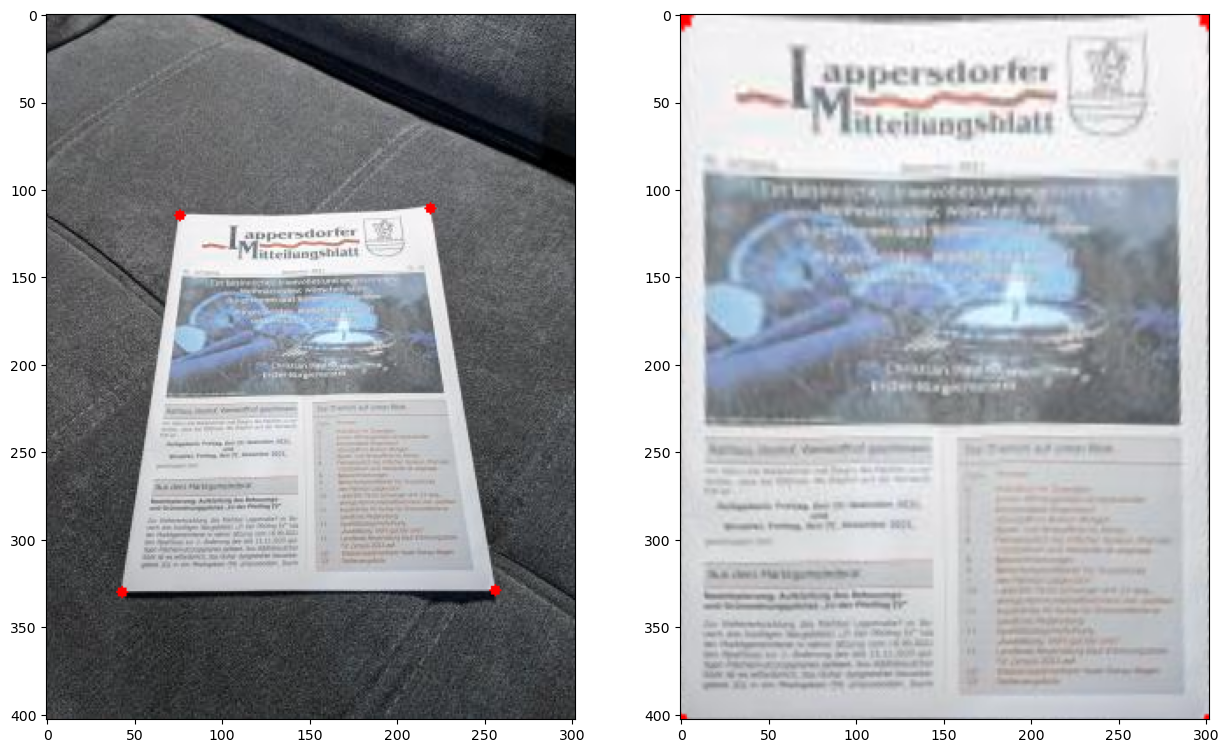

In [24]:
# Compute the homography matrix (you'll have to use getPerspectiveTransform function from OpenCV here)
M = cv2.getPerspectiveTransform(src, dst)
#M, mask = cv2.findHomography(src, dst, cv2.RANSAC)

# Build the rectified image using the computed matrix (you'll have to use warpPerspective function from OpenCV)
rectified = cv2.warpPerspective(img, M, (cols, rows), flags=cv2.INTER_LINEAR)

# Let's plot the results
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(rectified)


### Questions
* The affine transform does not seem to be working well in this case. Why? - Because affine transformation keeps lines parallel and  left and right side  of our destination image parallel to the source image.
* What can you tell me about the values you have obtained for the inliers vector? What does it mean? - It means which of our 4 points good for us (inlier) or not (outlier).
* How does the result from homography look? Does it work well enough? - Pretty good, but the top line doesn't fit well - it's a little bended.  And of course the quality is worse. 